# WASP Course: Artificial Intelligence and Machine Learning

Lecturer: Dave Zachariah

Assignment responsible: Niklas Gunnarsson, Carl Andersson, Daniel Gedon

# Student and Group Information

Fill this out for the submission of the assignment (you submit this notebook with your solution)

- **Student names:** <font color='red'>Yikun Hou, Yiran Wang</font>

- **Team ID:** <font color='red'>Y</font>

Make sure that the team id is the same as the one with which you submit your model predictions (see coding task 7) such that we can check your performance.

---
# Module 3 - Assignment Overview: ECG classification

The [electrocardiogram (ECG)](https://www.mayoclinic.org/tests-procedures/ekg/about/pac-20384983) records the electrical signals in the heart. It is a common  test used to quickly detect heart problems and to monitor the heart's health.
In this assignment you will implement and evaluate a model to classify whether the person has [atrial fibrillation (AF)](https://www.mayoclinic.org/diseases-conditions/atrial-fibrillation/symptoms-causes/syc-20350624.) or not based on measurements from the ECG exam.


**Submission:** You submit the deliverables (see below) at https://canvas.kth.se/courses/42324/assignments/254507

**Due Date:** August 25, 2023.

---
## Basic Tasks
Your task is to implement a classification model, train this model on training data, and evaluate its performance on validation data. We provide skeleton code for the implementation of a simple convolution neural network model.

The steps required to implement this model are presented as numbered tasks below. In total there are seven (7) coding tasks and five (5) explanation tasks.

## Competitive setting

You have to compute the predictions for the test data (you do not have the labels for it) and submit your predictions to be evaluated to a leaderboard. These predictions will be scored and your submission will be ranked according to the F1 score and compared with your colleagues. In the end a winning team will be determined.

### Deliverables
There are two deliverables:
1. You have to submit this Jupyter notebook on the course web-page (Canvas) together with your code and explanations (where asked for it) that describe your implementation and your experimental results. The notebook should run as a standalone in google colab.
2. You have to have at least **three (3)** submissions (for instructions on how to submit, see coding task 7) where you try to improve the model architecture, the training procedure or the problem formulation. In the submission of this notebook you have to provide a short explanation of what changed between each submission and justify why you decided to make these changes.

### Grading
To pass the assignment, you must submit a complete and working implementation of a model and a well-motivated description and evaluation of it. Your model should reach an Area under the ROC curve (AUROC) on the test data of at least 0.97 and an Average Precision (AP) score of 0.95. Note that the leaderboard to is sorted by F1 score and not AUROC, hence you would want to balance all three metrics.

### GPU Acceleration
To be able to use the GPUs provided by colab in order to speed up your computations, you want to check that the `Hardware accelerator` is set to `GPU` under `Runtime > change runtime type`. Note that notebooks run by connecting to virtual machines that have maximum lifetimes that can be as much as 12 hours. Notebooks will also disconnect from VMs when left idle for too long.

In [ ]:
import os

# helper function
def exists(path):
    val = os.path.exists(path)
    if val:
        print(f'{path} already exits. Using cached. Delete it manually to recieve it again!')
    return val

# clone requirements.txt if not yet available
if not exists('requirements.txt'):
    !git clone https://gist.github.com/dgedon/8a7b91714568dc35d0527233e9ceada4.git req
    !mv req/requirements.txt .
    !yes | rm -r req

requirements.txt already exits. Using cached. Delete it manually to recieve it again!


In [ ]:
# Install packages (python>=3.9 is required)
!pip install -r requirements.txt

In [ ]:
# Import
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, average_precision_score
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

---
## The data set

The dataset is a subset of the [*CODE dataset*](https://scilifelab.figshare.com/articles/dataset/CODE_dataset/15169716): an anotated database of ECGs. The ECG exams were recorded in Brazil by the Telehealth Network of the state Minas Gerais between 2010 and 2016. The dataset and its usage for the development of deep learning methods was described in ["Automatic diagnosis of the 12-lead ECG using a deep neural network"](https://www.nature.com/articles/s41467-020-15432-4).
The full dataset is available for research upon request.


For the training dataset you have labels.
For the test dataset you only have the ECG exams but no labels. Evaluation is done by submitting to the leaderboard.

Download the dataset from the given dropbox link and unzip the folder containing the files. The downloaded files are in WFDB format (see [here](https://www.physionet.org/content/wfdb-python/3.4.1/) for details).

In [ ]:
# 1. Download dataset
if not exists('codesubset.tar.gz'):
    !wget https://www.dropbox.com/s/9zkqa5y5jqakdil/codesubset.tar.gz?dl=0 -O codesubset.tar.gz

codesubset.tar.gz already exits. Using cached. Delete it manually to recieve it again!


In [ ]:
# 1. unzip the downloaded data set folder
if not exists('codesubset'):
    !tar -xf codesubset.tar.gz

codesubset already exits. Using cached. Delete it manually to recieve it again!


Note that the extraced folder 'codesubset' contains
1. subfolders with the ECG exam traces. These have to be further preprocessed which we do in the next steps.
2. a csv file which contain the labels and other features for the training data set.


### Preprocessing

Run the cells below to  Clone the GitHub repository which we use for [data preprocessing](https://github.com/antonior92/ecg-preprocessing).

In [ ]:
# 2. clone the code files for data preprocessing
if not exists('ecg-preprocessing'):
    !git clone https://github.com/antonior92/ecg-preprocessing.git

ecg-preprocessing already exits. Using cached. Delete it manually to recieve it again!


Let us plot an ECG sample. We can plot ECGs using the `ecg_plot` library for example by using the following code snippet where `ecg_sample` is an array of size `(number of leads * sequence length)`. Now we can view an ECG before preprocessing.

<Figure size 640x480 with 0 Axes>

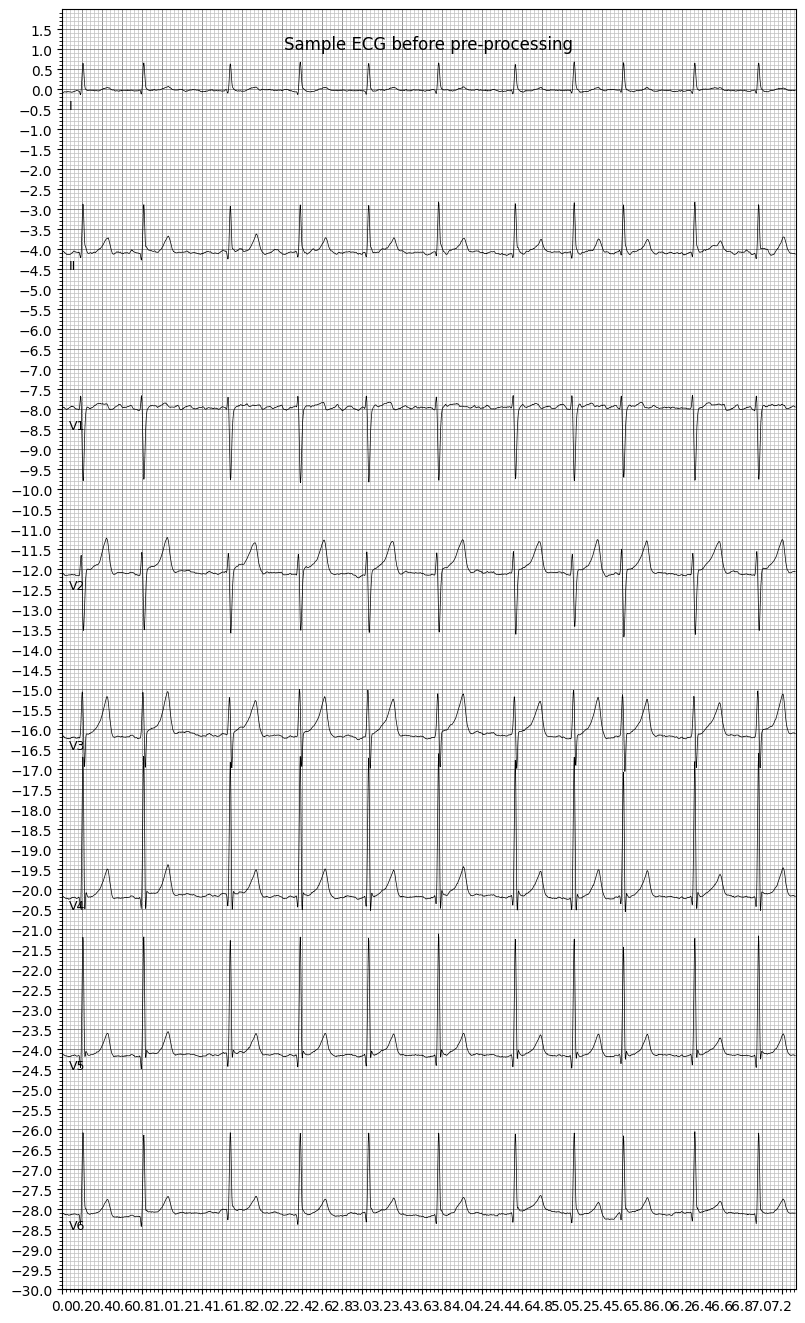

In [ ]:
import ecg_plot
runfile("ecg-preprocessing/read_ecg.py")

PATH_TO_WFDB = 'codesubset/train/TNMG100046'
ecg_sample, sample_rate, _ = read_ecg(PATH_TO_WFDB)

# ECG plot
plt.figure()
lead = ['I', 'II', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
ecg_plot.plot(ecg_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=1, title='Sample ECG before pre-processing')
plt.show()


The preprocessing consist of:
- resampling all ECG traces to the sample sampling period (400 Hz). Option: ``--new_freq 400``
- zero padding if necessary such that all ECG have the same number of samples (4096). Option: ``--new_len 4096``.
- removing trends in the ECG signal. Option: ``--remove_baseline``
- remove possible power line noise. Option: ``--powerline 60``

You can run the script bellow to plot the same ECG after the preprocessing.  The script also use the  `ecg_plot` library (as you did above).  You can try also with different command line options to see how the preprocessing affects the signal that will be used by the model.

Namespace(path='codesubset/train/TNMG100046', save='', remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')


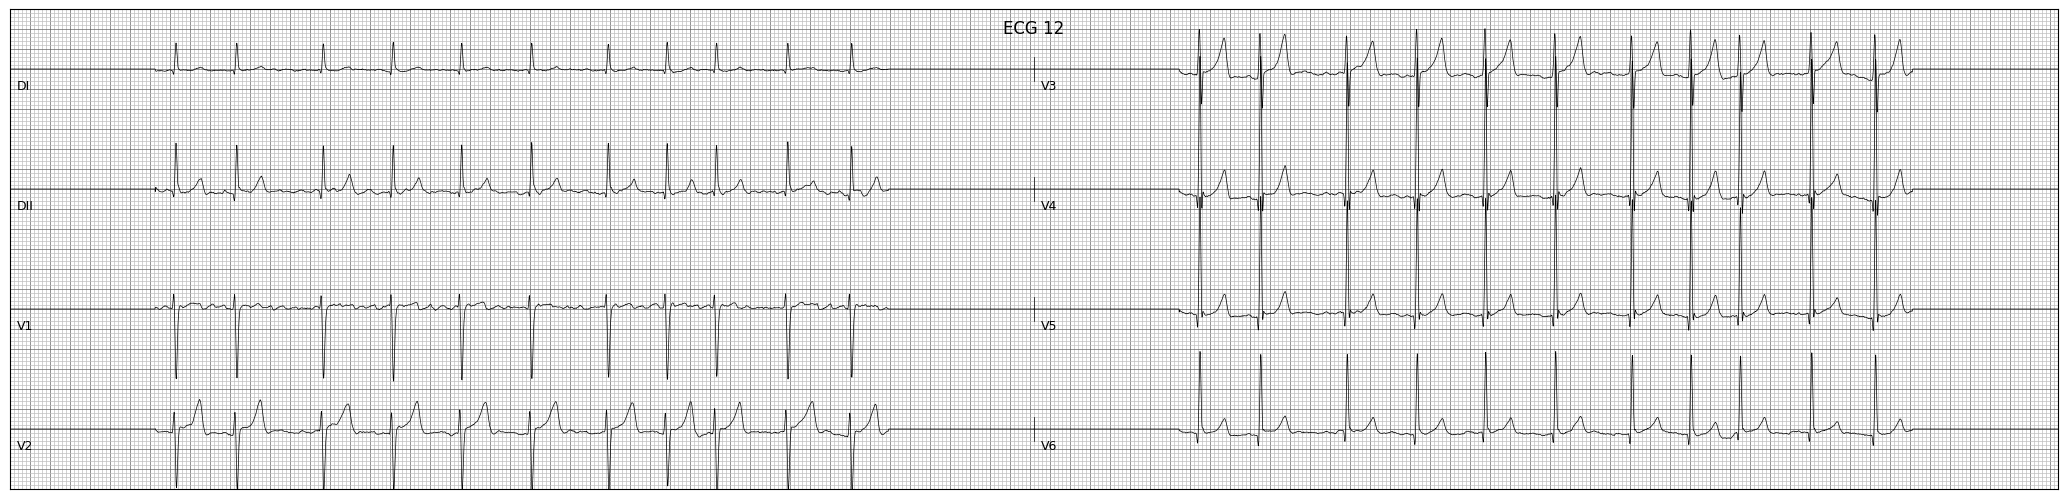

<Figure size 640x480 with 0 Axes>

In [ ]:
%run ecg-preprocessing/plot_from_ecg.py codesubset/train/TNMG100046 --new_freq 400 --new_len 4096 --remove_baseline --powerline 60


Next we perform the preprocessing in all exams and convert them into one single h5 file (see [here](https://www.h5py.org/#:~:text=The%20h5py%20package%20is%20a,they%20were%20real%20NumPy%20arrays.) for details about the format). The resulting h5 files contains the traces as arrays with the shape `(number of traces * sequence length * number of leads)` where sequence length is 4096 and number of leads is 8.
The files `train.h5` and `test.h5` will be saved inside the folder `codesubset/`.

In [ ]:
# 3. Generate train
if not exists('codesubset/train.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/train/RECORDS.txt codesubset/train.h5
# 3. Generate test
if not exists('codesubset/test.h5'):
    !python ecg-preprocessing/generate_h5.py --new_freq 400 --new_len 4096 --remove_baseline --powerline 60 codesubset/test/RECORDS.txt codesubset/test.h5

Namespace(input_file='codesubset/train/RECORDS.txt', out_file='codesubset/train.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 10000/10000 [01:17<00:00, 129.77it/s]
Namespace(input_file='codesubset/test/RECORDS.txt', out_file='codesubset/test.h5', root_dir=None, remove_baseline=True, new_len=4096, new_freq=400.0, scale=1, use_all_leads=False, powerline=60.0, fmt='wfdb')
100% 6000/6000 [00:52<00:00, 114.48it/s]


### Coding Task 1: Data Analysis

Before starting to model you have to analyse the dataset. You can be creative in your way of *getting a feeling* for the data. What you have to do is:
- plot an ECG after proprocessing saved in the hdf5 file. For this use the `ecg_plot()` example above and see below for how to access the preprocessed data in h5 format.

Some further ideas to explore are:
- check the balance of the data set,
- evaluate the distribution of age and sex of the patients,
- think about the performance that a best naive classifier would achieve, e.g. by random guessing or always predicting one class.

<br />

**How to access the data?**

You can acces the data in the h5 file in the following way
```
import h5py

PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']
```
Then, `data[i]` is an numpy array of the $i$th ECG exam (including all time points and leads).


<Figure size 640x480 with 0 Axes>

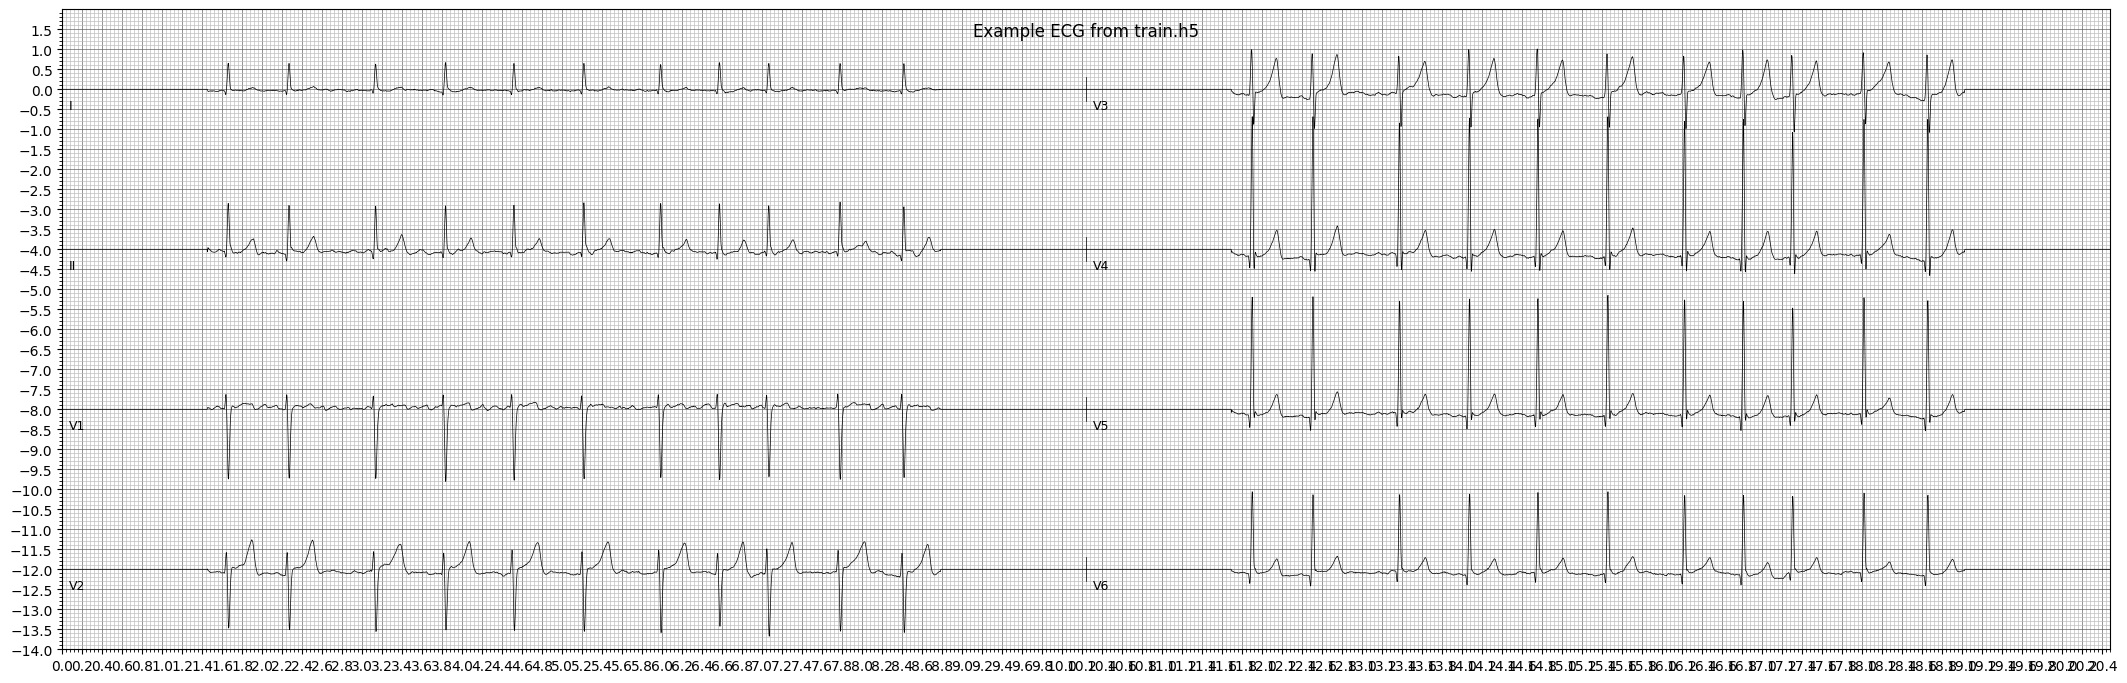

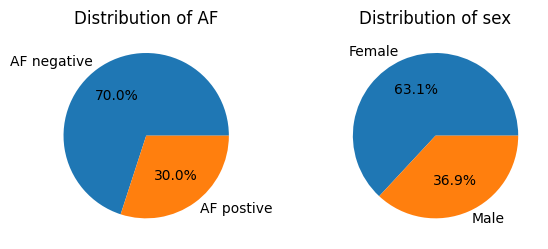

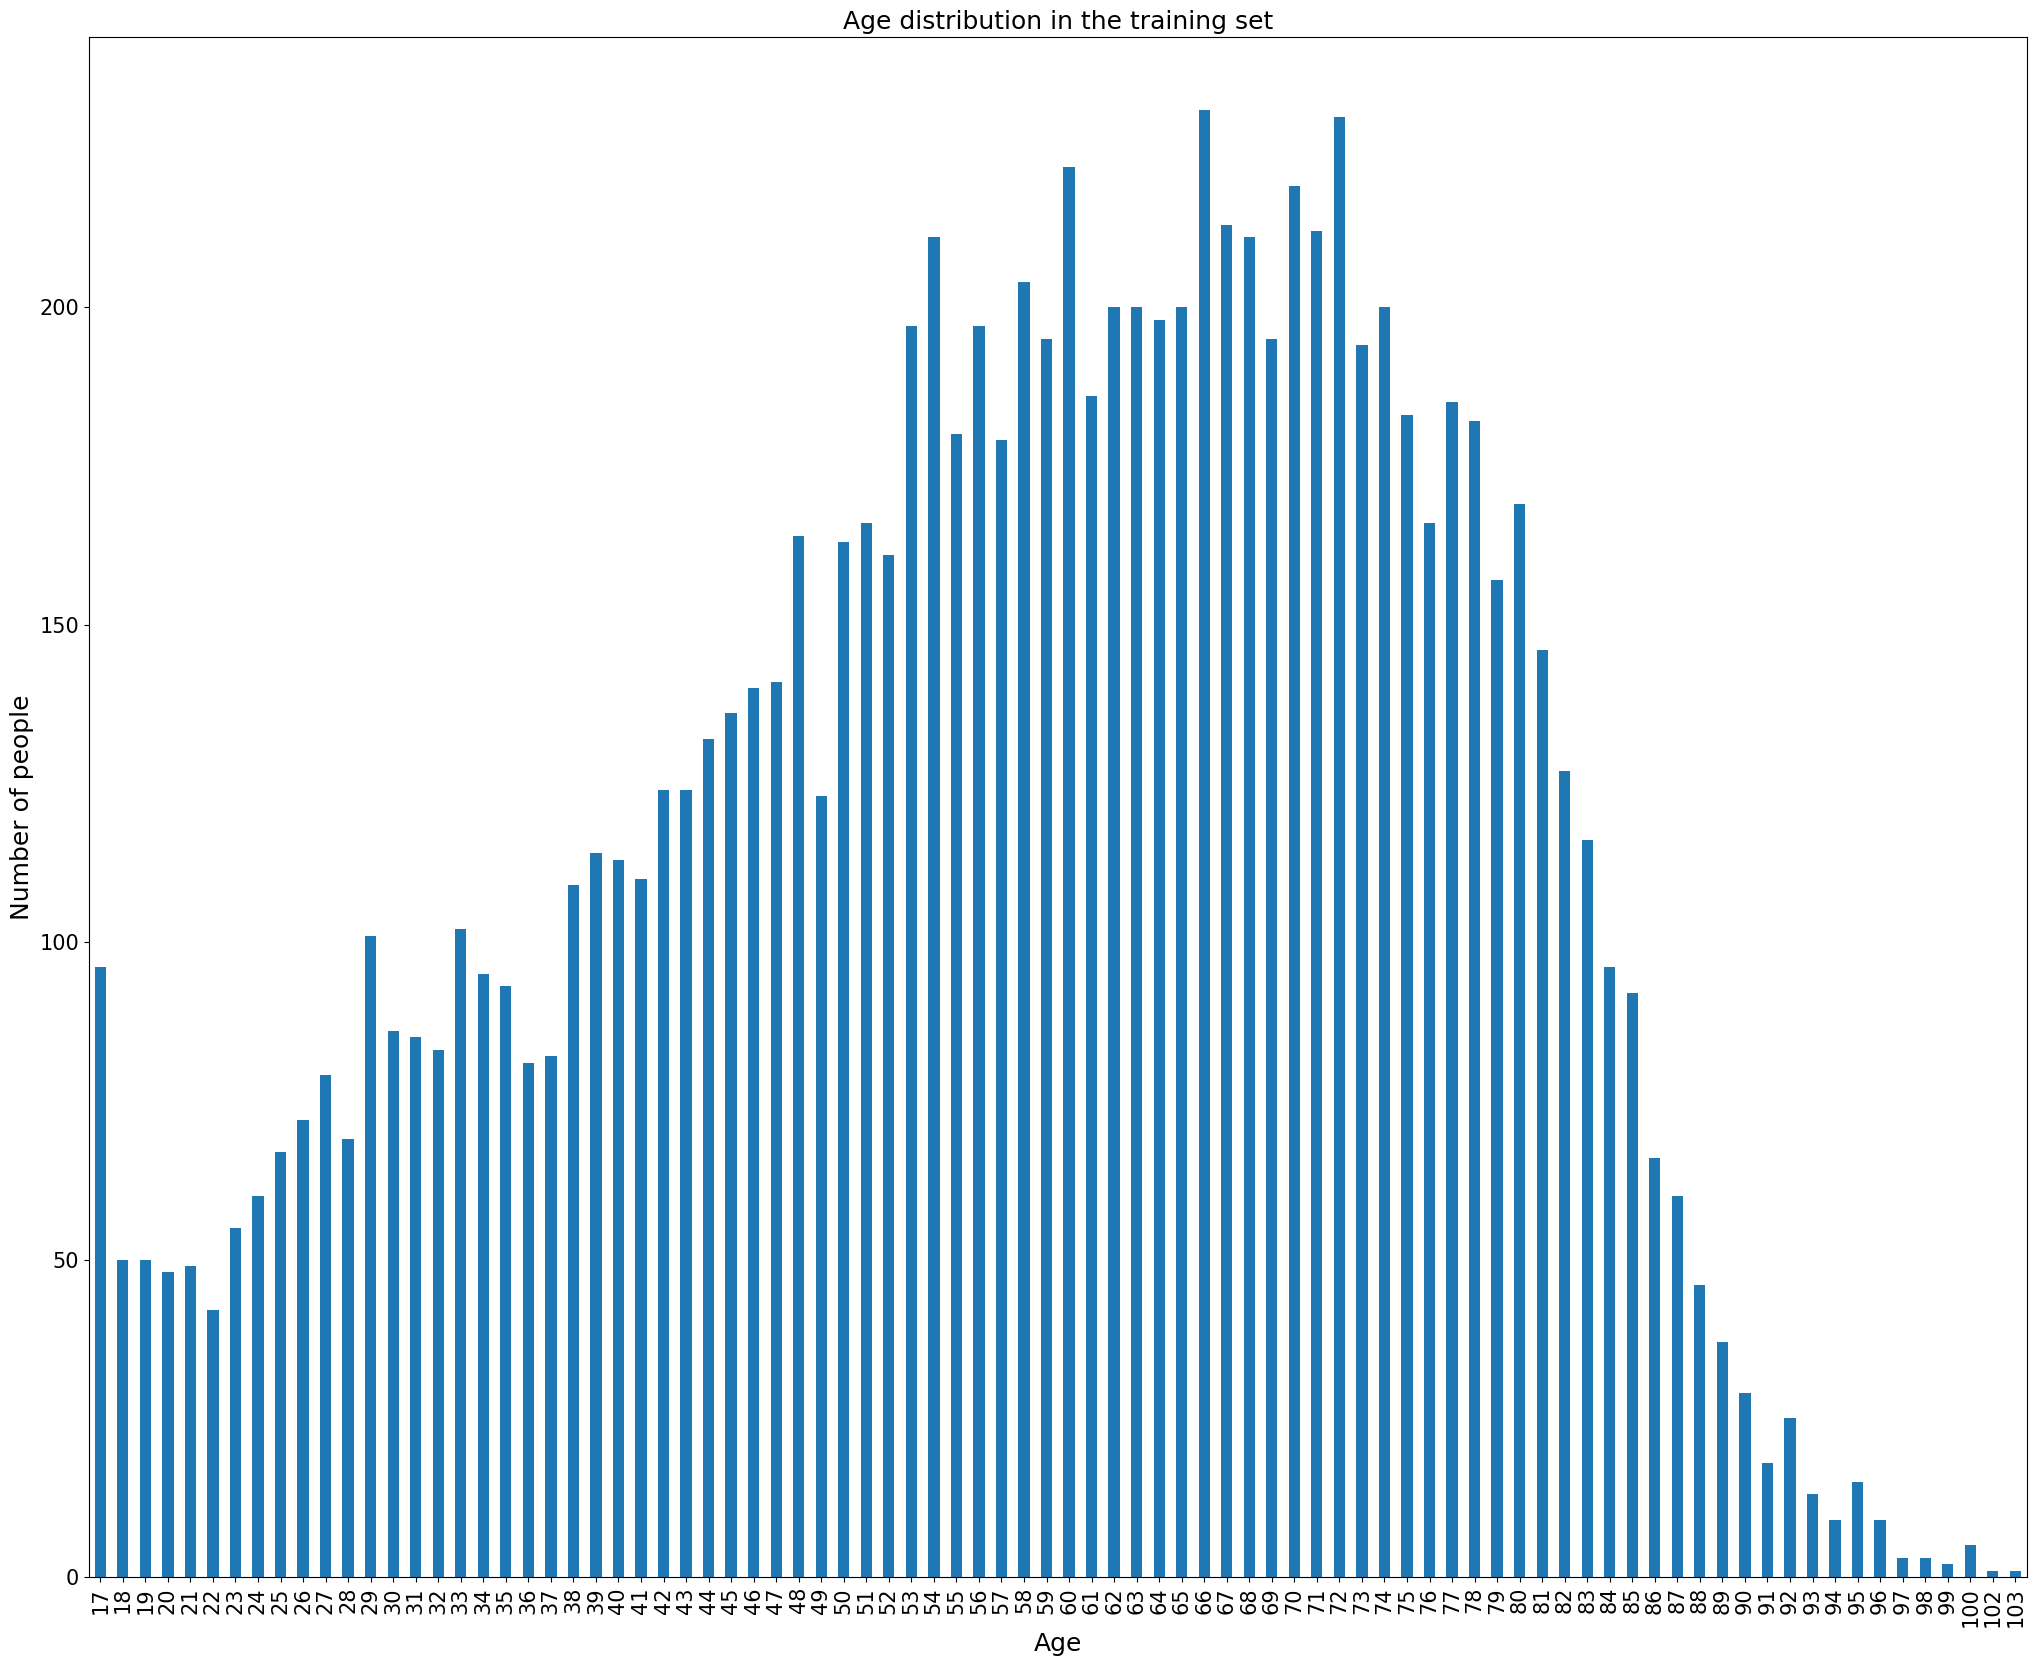

In [ ]:
"""
TASK: Insert your code here (Done)
"""
# plot ECG from .h5 file
import h5py
PATH_TO_H5_FILE = 'codesubset/train.h5'
f = h5py.File(PATH_TO_H5_FILE, 'r')
data = f['tracings']

data_sample = data[0].T # Transpose: Shape should be [8, 4096(Re-sampled length)] which has been verified by testing plot_from_ecg file
plt.figure()
# Value of "columns" can be 1 or 2 which matchs the figure format of first figure (before pre-processing) and second one.
ecg_plot.plot(data_sample, sample_rate=sample_rate, style='bw', row_height=8, lead_index=lead, columns=2, title='Example ECG from train.h5')
plt.show()

# Additional task 1: check the balance of the data set by poltting the labels
# Additional task 2: evaluate the distribution of sex & age
data_info = pd.read_csv('codesubset/train.csv')

AF_distribution = 'AF'
AF_counts = data_info[AF_distribution].value_counts()
labels_AF = ['AF negative', 'AF postive']
sizes_AF = [AF_counts[0], AF_counts[1]]

sex_distribution = 'sex'
sex_counts = data_info[sex_distribution].value_counts()
labels_sex = ['Female', 'Male']
sizes_sex = [sex_counts['F'], sex_counts['M']]

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.pie(sizes_AF, labels=labels_AF, autopct='%1.1f%%')
ax1.set_title('Distribution of AF')
ax2.pie(sizes_sex, labels=labels_sex, autopct='%1.1f%%')
ax2.set_title('Distribution of sex')
plt.subplots_adjust(wspace=0.4)
plt.show()

age_distribution = 'age'
age_counts = data_info[age_distribution].value_counts()
age_counts = age_counts.sort_index(ascending = True)

plt.figure(figsize = (25,20))
age_counts.plot(kind='bar')
plt.xlabel('Age',fontsize=18)
plt.ylabel('Number of people',fontsize=18)
plt.title('Age distribution in the training set',fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
# Additional task 3: naive classifier by always predicting the most frequent class
# It would achieve an accuracy of 0.7 if the test dataset shares a similar distribution of the training dataset
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")

dummy_clf.fit(data_info[sex_distribution], data_info[AF_distribution])
#dummy_clf.score(data_info[sex_distribution], data_info[AF_distribution])

DummyClassifier(strategy='most_frequent')

### Explanation task 1: Data Analysis

Please explain your main findings of the data analysis task in a few bullet points. Explain also what the preprocessing does and why it is necessary.

<br />

**<font color='red'>Your explanation here:</font>**

* The dataset is imbalanced with the target variable being as 3000 AF postive patients and 7000 AF negative patients samples.
* A naive classifier which always predicts the most frequent class (AF negative) can achieve 0.7 accuracy on datasets with the same distribution (i.e. AF negatives : AF positives = 7:3).
* The input feature 'sex' is also not balanced (i.e. 6307 females and 3693 males), which may lead to a biased model.
* In this task, four pre-processing methods are applied, including resampling which makes the wave lengths equal across different records, padding which makes all sequences share the same length, removing trends which can let the model more focus on the temporal variations of the signal, and removing possible power line noise which eliminate power-line (PL) interference. The pre-processing is to clean and normalize the datasets, make data values consistent, and remove noise. It makes later ML models learn from data more effectively and improve the model performance.


---
## Model

The model class consists of two methods:
- `__init__(self, args)`: This methods initializes the class, e.g. by using `mymodel=ModelBaseline(args)`.
- `forward(self,input_data)`: This method is called when we run `model_output=mymodel(input_data)`.

The dimension of the input data is  `(batch size * sequence length * number of leads)`. Where **batch size** is a hyperparameter, **sequence length** is the number of ECG time samples (=4096) and **number of leads** (=8).

The `ModelBaseline` (provided below) is a 2 layer model with one convolutional layers and one linear layer. Some explanations:
- The conv layer downsamples the input traces from 4096 samples to 128 samples and increases the number of channels from 8 (=number of leads) to 32. Here we use a kernel size of 3.
- The linear layer uses the flattened output from the conv and outputs one prediction. Since we have a binary problem, a single prediction is sufficient.


In [ ]:
class ModelBaseline(nn.Module):
    def __init__(self,):
        super(ModelBaseline, self).__init__()
        self.kernel_size = 3

        # conv layer
        downsample = self._downsample(4096, 128) # == 32

        self.conv1 = nn.Conv1d(in_channels=8,
                               out_channels=32,
                               kernel_size=self.kernel_size,
                               stride=downsample,
                               padding=self._padding(downsample),
                               bias=False)

        # linear layer
        self.lin = nn.Linear(in_features=32*128,
                             out_features=1)

        # ReLU
        self.relu = nn.ReLU()

    def _padding(self, downsample):
        return max(0, int(np.floor((self.kernel_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)


    def forward(self, x):
        x= x.transpose(2,1)

        x = self.relu(self.conv1(x))

        x_flat= x.view(x.size(0), -1)
        x = self.lin(x_flat)

        return x

### Coding Task 2: Define your model

In the cell below you have to define your model. You can be inspired by the baseline model above but you can also define any other kind of neural network architecture.

In [ ]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
        self.kernel_size_conv1 = 16
        self.kernel_size_conv2 = 9
        self.kernel_size_conv3 = 7
        self.kernel_size_conv4 = 5
        self.kernel_size_conv5 = 3

        channel_in = 8

        conv1_in = 4096
        conv1_out = 2048
        out_channels_conv1 = 128

        conv2_in = conv1_out
        conv2_out = 1024
        out_channels_conv2 = 256

        conv3_in = conv2_out
        conv3_out = 512
        out_channels_conv3 = 512

        conv4_in = conv3_out
        conv4_out = 256
        out_channels_conv4 = 1024

        conv5_in = conv4_out
        conv5_out = 128
        out_channels_conv5 = 1024

        downsample_conv1 = self._downsample(conv1_in, conv1_out)
        self.conv1 = nn.Conv1d(in_channels = channel_in,
                               out_channels = out_channels_conv1,
                               kernel_size = self.kernel_size_conv1,
                               stride = downsample_conv1,
                               padding = self._padding(self.kernel_size_conv1, downsample_conv1),
                               bias = False)
        self.bn1 = nn.BatchNorm1d(out_channels_conv1)

        downsample_conv2 = self._downsample(conv2_in, conv2_out)
        self.conv2 = nn.Conv1d(in_channels = out_channels_conv1,
                               out_channels = out_channels_conv2,
                               kernel_size = self.kernel_size_conv2,
                               stride = downsample_conv2,
                               padding = self._padding(self.kernel_size_conv2, downsample_conv2),
                               bias = False)
        self.bn2 = nn.BatchNorm1d(out_channels_conv2)

        downsample_conv3 = self._downsample(conv3_in, conv3_out)
        self.conv3 = nn.Conv1d(in_channels = out_channels_conv2,
                               out_channels = out_channels_conv3,
                               kernel_size = self.kernel_size_conv3,
                               stride = downsample_conv3,
                               padding = self._padding(self.kernel_size_conv3, downsample_conv3),
                               bias = False)
        self.bn3 = nn.BatchNorm1d(out_channels_conv3)

        downsample_conv4 = self._downsample(conv4_in, conv4_out)
        self.conv4 = nn.Conv1d(in_channels = out_channels_conv3,
                               out_channels = out_channels_conv4,
                               kernel_size = self.kernel_size_conv4,
                               stride = downsample_conv4,
                               padding = self._padding(self.kernel_size_conv4, downsample_conv4),
                               bias = False)
        self.bn4 = nn.BatchNorm1d(out_channels_conv4)

        downsample_conv5 = self._downsample(conv5_in, conv5_out)
        self.conv5 = nn.Conv1d(in_channels = out_channels_conv4,
                               out_channels = out_channels_conv5,
                               kernel_size = self.kernel_size_conv5,
                               stride = downsample_conv5,
                               padding = self._padding(self.kernel_size_conv5, downsample_conv5),
                               bias = False)
        self.bn5 = nn.BatchNorm1d(out_channels_conv5)

        self.fc1 = nn.Linear(in_features = self._calFCin(out_channels_conv5, conv5_out, 5), out_features = 512)

        self.dropout = nn.Dropout(p = 0.5)
        
        self.fc2 = nn.Linear(in_features = 512, out_features = 1)

    def _padding(self, k_size, downsample):
        return max(0, int(np.floor((k_size - downsample + 1) / 2)))

    def _downsample(self, seq_len_in, seq_len_out):
        return int(seq_len_in // seq_len_out)

    def _calFCin(self, orig_c, orig_o, num_pool):
        fc_in = orig_c * orig_o
        for i in range (0, num_pool):
          fc_in = (fc_in - 2) // 2 + 1
        return fc_in

    def forward(self, x):
        x = x.transpose(2,1)

        x = nn.functional.leaky_relu(self.conv1(x))
        x = self.bn1(x)
        x = nn.functional.max_pool1d(x, kernel_size = 2)
        x = self.dropout(x)

        x = nn.functional.leaky_relu(self.conv2(x))
        x = self.bn2(x)
        x = nn.functional.max_pool1d(x, kernel_size = 2)
        x = self.dropout(x)

        x = nn.functional.leaky_relu(self.conv3(x))
        x = self.bn3(x)
        x = nn.functional.max_pool1d(x, kernel_size = 2)
        x = self.dropout(x)

        x = nn.functional.leaky_relu(self.conv4(x))
        x = self.bn4(x)
        x = nn.functional.max_pool1d(x, kernel_size = 2)
        x = self.dropout(x)

        x = nn.functional.leaky_relu(self.conv5(x))
        x = self.bn5(x)
        x = nn.functional.max_pool1d(x, kernel_size = 2)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.dropout(x)
        x = nn.functional.leaky_relu(x)

        x = self.fc2(x)
        x = self.dropout(x)

        return x

### Explanation Task 2: Final Model
Please explain and motivate in short sentences or bullet points the choice of your final model.

<br />


**<font color='red'>Your explanation here:</font>**

This model consist of 5 convolution blocks, followed by a linear layer, a drop out layer, and another fully connected linear layer. Each block has 1 convolutional layer with decreasing size of kernels and 1 batch normalization layer. In the forward function, we use leaky relu as activation function, and we also use maxpooling layer to help reduce the spatial size.

Convolutional layers are to effectively learn patterns in sparse data. Batch normalization layers rescale and recenter input data, which helps training process faster and more stable. Dropout layers are to prevent the model from overfitting. We experimented different settings and ended up using 5 blocks of convolutional layers in the model. This setting shows an optimal result for the model to be of good performance as well as not overfitting or costing unnessesary computational resources. We used more kernels to capture larger spatial patterns at first, then use fewer kernels to learn more fine-grained details.


---
## Train function

The function `train(...)` is called to in every epoch to train the model. The function loads the training data, makes predictions, compares predictions with true labels in the loss function and adapting the model parameters using stochastic gradient descent.

In the code cell below there is the basic structure to load data from the data loader and to log your loss. The arguments of the function are explained by the use in the `main(...)` function below.

If you are unfamiliar with PyTorch training loops, then this official [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) might help (especially section "4. Train your Network").

### Coding Task 3: Fill training loop

Fill the code cell below such that the model is training when `train(...)` is called.

In [ ]:
def train_loop(epoch, dataloader, model, optimizer, loss_function, device):
    # model to training mode (important to correctly handle dropout or batchnorm layers)
    model.train()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    # progress bar def
    train_pbar = tqdm(dataloader, desc="Training Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # training loop
    for traces, diagnoses in train_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces.to(device), diagnoses.to(device)

        """
        TASK: Insert your code here. This task can be done in 5 lines of code.
        """
        optimizer.zero_grad()
        model_out = model.forward(traces)
        loss = loss_function(model_out, diagnoses.float())
        loss.backward()
        optimizer.step()

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        train_pbar.set_postfix({'loss': total_loss / n_entries})
    train_pbar.close()
    return total_loss / n_entries

---
## Eval function

The `eval(...)` function is similar to the `train(...)` function but is used to evaluate the model on validation data without adapting the model parameters. You can prohibit computing gradients by using a `with torch.no_grad():` statement.

Currenlty only the loss is logged here. Additionally you have to collect all your predictions and the true values in order to compute more metrics such as AUROC.

### Coding Task 4: Fill evaluation loop
Fill the code cell below such we obtain model predictions to evaluate the validation loss and collect the predictoin in order to compute other validation metrics in the `main(...)` function.

In [ ]:
def eval_loop(epoch, dataloader, model, loss_function, device):
    # model to evaluation mode (important to correctly handle dropout or batchnorm layers)
    model.eval()
    # allocation
    total_loss = 0  # accumulated loss
    n_entries = 0   # accumulated number of data points
    valid_pred, valid_true = [], []
    # progress bar def
    eval_pbar = tqdm(dataloader, desc="Evaluation Epoch {epoch:2d}".format(epoch=epoch), leave=True)
    # evaluation loop
    for traces_cpu, diagnoses_cpu in eval_pbar:
        # data to device (CPU or GPU if available)
        traces, diagnoses = traces_cpu.to(device), diagnoses_cpu.to(device)

        """
        TASK: Insert your code here. This task can be done in 6 lines of code. (Done)
        """
        with torch.no_grad():
          model_predications = model.forward(traces)
          loss = loss_function(model_predications, diagnoses.float())
          valid_pred.append(model_predications.detach().cpu().numpy())
          valid_true.append(diagnoses.detach().cpu().numpy())

        # Update accumulated values
        total_loss += loss.detach().cpu().numpy()
        n_entries += len(traces)

        # Update progress bar
        eval_pbar.set_postfix({'loss': total_loss / n_entries})
    eval_pbar.close()
    return total_loss / n_entries, np.vstack(valid_pred), np.vstack(valid_true)

---
## Run Training

In the code cell below there are some initial (non-optimal!) training hyperparameters. Further, we combine everything from above into training code. That means that we build the dataloaders, define the model/loss/optimizer and then train/validate the model over multiple epochs. Here, we save the model with the lowest validation loss as the best model.

### Coding Task 5: Combine everything to train/validate the model

The following tasks are necessary in the code below
- split the data into training and validation data
- define the loss function
- decide and implement validation metric(s) to evaluate and compare the model on

Optional task:
- include learning rate scheduler
- take specific care about possible data inbalance

### Coding Task 6: Run your model and adapt hyperparameters

After you combined everything in task 5, now you run the code to evaluate the model. Based on the resulting validation metrics you tune
- the training hyperparameters
- the model architecture
- the model hyperparameters.

### Explanation Task 3: Hyperparameter
Please explain and motivate in short sentences or bullet points the final choice of hyperparamer and how you developed them.

<br />


**<font color='red'>Your explanation here:</font>**

* We applied learning rate scheduler which reduces learning rate with the learning rate decay strategy. High learning rate may cause the occillision around the minimum point. However, it might be trapped into local minimum.
* We set the number of epochs to be 100, because the learning curve gets stablized around there and too many epochs are not necessary.
* The batch size we chose is 32, because a large batch size leads to slower convergence and batch size being too small can cause unstable training process.

In [ ]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# choose variables
"""
TASK: Adapt the following hyperparameters if necessary
"""
learning_rate = 1e-4
weight_decay = 1e-2
num_epochs = 100
batch_size = 32

In [ ]:
from torch.utils.data import TensorDataset, random_split, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

# =============== Build data loaders ======================================#
tqdm.write("Building data loaders...")

path_to_h5_train, path_to_csv_train, path_to_records = 'codesubset/train.h5', 'codesubset/train.csv', 'codesubset/train/RECORDS.txt'
# load traces
traces = torch.tensor(h5py.File(path_to_h5_train, 'r')['tracings'][()], dtype=torch.float32)
# load labels
ids_traces = [int(x.split('TNMG')[1]) for x in list(pd.read_csv(path_to_records, header=None)[0])] # Get order of ids in traces
df = pd.read_csv(path_to_csv_train)
df.set_index('id_exam', inplace=True)
df = df.reindex(ids_traces) # make sure the order is the same
labels = torch.tensor(np.array(df['AF']), dtype=torch.float32).reshape(-1,1)
# load dataset
dataset = TensorDataset(traces, labels)
len_dataset = len(dataset)
n_classes = len(torch.unique(labels))
# split data
"""
TASK: Split the dataset in train and validation; Insert your code here.
This can be done in <=4 line of code
"""
training_ratio = 0.8
train_size = int(training_ratio * len_dataset)
validation_size = len_dataset - train_size
dataset_train, dataset_valid = torch.utils.data.random_split(dataset, [train_size, validation_size])

# build data loaders
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)
tqdm.write("Done!\n")

Use device: cuda

Building data loaders...
Done!



In [ ]:
# =============== Define model ============================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()
model.to(device=device)
tqdm.write("Done!\n")

# =============== Define loss function ====================================#
"""
TASK: define the loss; Insert your code here. This can be done in 1 line of code
"""
loss_function = nn.BCEWithLogitsLoss()

# =============== Define optimizer ========================================#
tqdm.write("Define optimiser...")
# Notice we change Adam to NAdam
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
tqdm.write("Done!\n")

# =============== Define lr scheduler =====================================#
# TODO advanced students (non mandatory)
"""
OPTIONAL: define a learning rate scheduler; Insert your code here
"""
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, verbose=True)


# =============== Train model =============================================#
tqdm.write("Training...")
best_loss = np.Inf

# allocation
train_loss_all, valid_loss_all = [], []

## This code block for additional analysis
auroc = []
avg_pre = []
acc_s = []
f1_s = []
####################################

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    train_loss = train_loop(epoch, train_dataloader, model, optimizer, loss_function, device)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop(epoch, valid_dataloader, model, loss_function, device)
    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)

    # compute validation metrics for performance evaluation

    """
    TASK: compute validation metrics (e.g. AUROC); Insert your code here
    This can be done e.g. in 5 lines of code
    """
    y_pred_labels = torch.sigmoid(torch.tensor(y_pred)) > 0.5
    y_pred_labels_np = y_pred_labels.numpy()
    auroc.append(roc_auc_score(y_true, y_pred))

    ## Here are other metircs to satisify the requirement
    avg_pre.append(average_precision_score(y_true, y_pred))
    acc_s.append(accuracy_score(y_true, y_pred_labels_np))
    f1_s.append(f1_score(y_true, y_pred_labels_np))
    #print("AUROC: {:.4f}; AP: {:.4f}; ACC: {:.4f}; F1: {:.4f} in epoch {}\n".format(auroc[epoch-1], avg_pre[epoch-1], acc_s[epoch-1], f1_s[epoch-1], epoch))

    # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, 'model.pth')
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        model_save=model_save_state)
                    )

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step(valid_loss)

Define model...
Done!

Define optimiser...
Done!

Training...


  0%|          | 0/100 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 0.020474 	Valid Loss 0.018808 	Best model -> saved


Training Epoch  2:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 0.018001 	Valid Loss 0.014524 	Best model -> saved


Training Epoch  3:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 0.016700 	Valid Loss 0.012857 	Best model -> saved


Training Epoch  4:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 0.015880 	Valid Loss 0.011135 	Best model -> saved


Training Epoch  5:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 0.014755 	Valid Loss 0.009525 	Best model -> saved


Training Epoch  6:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 0.014426 	Valid Loss 0.006267 	Best model -> saved


Training Epoch  7:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 0.013785 	Valid Loss 0.006520 	


Training Epoch  8:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 0.013780 	Valid Loss 0.005588 	Best model -> saved


Training Epoch  9:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 0.013562 	Valid Loss 0.006043 	


Training Epoch 10:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 0.013157 	Valid Loss 0.005573 	Best model -> saved


Training Epoch 11:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 0.013132 	Valid Loss 0.005437 	Best model -> saved


Training Epoch 12:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 0.012839 	Valid Loss 0.004985 	Best model -> saved


Training Epoch 13:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 0.012841 	Valid Loss 0.004835 	Best model -> saved


Training Epoch 14:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 0.012937 	Valid Loss 0.004677 	Best model -> saved


Training Epoch 15:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 0.012566 	Valid Loss 0.004720 	


Training Epoch 16:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16: 	Train Loss 0.012773 	Valid Loss 0.005263 	


Training Epoch 17:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17: 	Train Loss 0.012595 	Valid Loss 0.004328 	Best model -> saved


Training Epoch 18:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18: 	Train Loss 0.012453 	Valid Loss 0.004932 	


Training Epoch 19:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19: 	Train Loss 0.012751 	Valid Loss 0.004259 	Best model -> saved


Training Epoch 20:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20: 	Train Loss 0.012769 	Valid Loss 0.004993 	


Training Epoch 21:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 21:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21: 	Train Loss 0.012476 	Valid Loss 0.004760 	


Training Epoch 22:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 22:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22: 	Train Loss 0.012473 	Valid Loss 0.004366 	


Training Epoch 23:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 23:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23: 	Train Loss 0.012600 	Valid Loss 0.004704 	


Training Epoch 24:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 24:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24: 	Train Loss 0.012707 	Valid Loss 0.005481 	


Training Epoch 25:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 25:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25: 	Train Loss 0.012636 	Valid Loss 0.005244 	
Epoch 00025: reducing learning rate of group 0 to 8.0000e-05.


Training Epoch 26:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 26:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26: 	Train Loss 0.012199 	Valid Loss 0.004983 	


Training Epoch 27:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 27:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27: 	Train Loss 0.012448 	Valid Loss 0.005913 	


Training Epoch 28:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 28:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28: 	Train Loss 0.012214 	Valid Loss 0.005599 	


Training Epoch 29:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 29:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29: 	Train Loss 0.012502 	Valid Loss 0.004526 	


Training Epoch 30:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 30:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30: 	Train Loss 0.012483 	Valid Loss 0.004727 	


Training Epoch 31:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 31:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31: 	Train Loss 0.012092 	Valid Loss 0.004336 	
Epoch 00031: reducing learning rate of group 0 to 6.4000e-05.


Training Epoch 32:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 32:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32: 	Train Loss 0.012295 	Valid Loss 0.004971 	


Training Epoch 33:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 33:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33: 	Train Loss 0.012216 	Valid Loss 0.004810 	


Training Epoch 34:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 34:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34: 	Train Loss 0.012638 	Valid Loss 0.004917 	


Training Epoch 35:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 35:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35: 	Train Loss 0.012463 	Valid Loss 0.004623 	


Training Epoch 36:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 36:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36: 	Train Loss 0.012267 	Valid Loss 0.004760 	


Training Epoch 37:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 37:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37: 	Train Loss 0.012208 	Valid Loss 0.004446 	
Epoch 00037: reducing learning rate of group 0 to 5.1200e-05.


Training Epoch 38:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 38:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38: 	Train Loss 0.012076 	Valid Loss 0.004376 	


Training Epoch 39:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 39:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39: 	Train Loss 0.012166 	Valid Loss 0.004964 	


Training Epoch 40:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 40:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40: 	Train Loss 0.012200 	Valid Loss 0.004568 	


Training Epoch 41:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 41:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41: 	Train Loss 0.011889 	Valid Loss 0.004548 	


Training Epoch 42:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 42:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42: 	Train Loss 0.012001 	Valid Loss 0.005130 	


Training Epoch 43:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 43:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43: 	Train Loss 0.012067 	Valid Loss 0.005113 	
Epoch 00043: reducing learning rate of group 0 to 4.0960e-05.


Training Epoch 44:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 44:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44: 	Train Loss 0.011853 	Valid Loss 0.003796 	Best model -> saved


Training Epoch 45:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 45:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45: 	Train Loss 0.012159 	Valid Loss 0.004296 	


Training Epoch 46:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 46:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46: 	Train Loss 0.011718 	Valid Loss 0.003927 	


Training Epoch 47:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 47:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47: 	Train Loss 0.012097 	Valid Loss 0.005233 	


Training Epoch 48:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 48:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48: 	Train Loss 0.011952 	Valid Loss 0.004708 	


Training Epoch 49:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 49:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49: 	Train Loss 0.011758 	Valid Loss 0.003907 	


Training Epoch 50:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 50:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50: 	Train Loss 0.011762 	Valid Loss 0.004055 	
Epoch 00050: reducing learning rate of group 0 to 3.2768e-05.


Training Epoch 51:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 51:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51: 	Train Loss 0.011823 	Valid Loss 0.003790 	Best model -> saved


Training Epoch 52:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 52:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52: 	Train Loss 0.012039 	Valid Loss 0.004322 	


Training Epoch 53:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 53:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53: 	Train Loss 0.011919 	Valid Loss 0.003884 	


Training Epoch 54:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 54:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54: 	Train Loss 0.011886 	Valid Loss 0.003975 	


Training Epoch 55:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 55:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55: 	Train Loss 0.011924 	Valid Loss 0.004432 	


Training Epoch 56:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 56:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56: 	Train Loss 0.011906 	Valid Loss 0.004365 	


Training Epoch 57:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 57:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57: 	Train Loss 0.011898 	Valid Loss 0.004649 	
Epoch 00057: reducing learning rate of group 0 to 2.6214e-05.


Training Epoch 58:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 58:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58: 	Train Loss 0.011702 	Valid Loss 0.004093 	


Training Epoch 59:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 59:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59: 	Train Loss 0.011576 	Valid Loss 0.003927 	


Training Epoch 60:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 60:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60: 	Train Loss 0.011471 	Valid Loss 0.003994 	


Training Epoch 61:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 61:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61: 	Train Loss 0.011617 	Valid Loss 0.003963 	


Training Epoch 62:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 62:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62: 	Train Loss 0.011497 	Valid Loss 0.003981 	


Training Epoch 63:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 63:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63: 	Train Loss 0.011624 	Valid Loss 0.004120 	
Epoch 00063: reducing learning rate of group 0 to 2.0972e-05.


Training Epoch 64:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 64:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64: 	Train Loss 0.011546 	Valid Loss 0.003995 	


Training Epoch 65:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 65:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 65: 	Train Loss 0.011513 	Valid Loss 0.004022 	


Training Epoch 66:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 66:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 66: 	Train Loss 0.011434 	Valid Loss 0.004093 	


Training Epoch 67:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 67:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 67: 	Train Loss 0.011436 	Valid Loss 0.004251 	


Training Epoch 68:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 68:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 68: 	Train Loss 0.011649 	Valid Loss 0.003895 	


Training Epoch 69:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 69:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 69: 	Train Loss 0.011301 	Valid Loss 0.003896 	
Epoch 00069: reducing learning rate of group 0 to 1.6777e-05.


Training Epoch 70:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 70:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 70: 	Train Loss 0.011446 	Valid Loss 0.004151 	


Training Epoch 71:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 71:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 71: 	Train Loss 0.011446 	Valid Loss 0.004019 	


Training Epoch 72:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 72:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 72: 	Train Loss 0.011411 	Valid Loss 0.003912 	


Training Epoch 73:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 73:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 73: 	Train Loss 0.011300 	Valid Loss 0.004153 	


Training Epoch 74:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 74:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 74: 	Train Loss 0.011494 	Valid Loss 0.004524 	


Training Epoch 75:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 75:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 75: 	Train Loss 0.011348 	Valid Loss 0.004219 	
Epoch 00075: reducing learning rate of group 0 to 1.3422e-05.


Training Epoch 76:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 76:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 76: 	Train Loss 0.011290 	Valid Loss 0.004065 	


Training Epoch 77:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 77:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 77: 	Train Loss 0.011184 	Valid Loss 0.003877 	


Training Epoch 78:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 78:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 78: 	Train Loss 0.011249 	Valid Loss 0.003959 	


Training Epoch 79:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 79:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 79: 	Train Loss 0.011409 	Valid Loss 0.004104 	


Training Epoch 80:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 80:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 80: 	Train Loss 0.011527 	Valid Loss 0.004106 	


Training Epoch 81:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 81:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 81: 	Train Loss 0.011235 	Valid Loss 0.004097 	
Epoch 00081: reducing learning rate of group 0 to 1.0737e-05.


Training Epoch 82:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 82:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 82: 	Train Loss 0.011253 	Valid Loss 0.004543 	


Training Epoch 83:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 83:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 83: 	Train Loss 0.011213 	Valid Loss 0.004017 	


Training Epoch 84:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 84:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 84: 	Train Loss 0.011238 	Valid Loss 0.003913 	


Training Epoch 85:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 85:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 85: 	Train Loss 0.011132 	Valid Loss 0.004474 	


Training Epoch 86:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 86:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 86: 	Train Loss 0.011055 	Valid Loss 0.004046 	


Training Epoch 87:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 87:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 87: 	Train Loss 0.011275 	Valid Loss 0.003834 	
Epoch 00087: reducing learning rate of group 0 to 8.5899e-06.


Training Epoch 88:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 88:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 88: 	Train Loss 0.011211 	Valid Loss 0.004029 	


Training Epoch 89:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 89:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 89: 	Train Loss 0.011042 	Valid Loss 0.003823 	


Training Epoch 90:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 90:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 90: 	Train Loss 0.011259 	Valid Loss 0.004034 	


Training Epoch 91:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 91:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 91: 	Train Loss 0.010996 	Valid Loss 0.003937 	


Training Epoch 92:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 92:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 92: 	Train Loss 0.011072 	Valid Loss 0.003966 	


Training Epoch 93:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 93:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 93: 	Train Loss 0.011083 	Valid Loss 0.003804 	
Epoch 00093: reducing learning rate of group 0 to 6.8719e-06.


Training Epoch 94:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 94:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 94: 	Train Loss 0.011319 	Valid Loss 0.003896 	


Training Epoch 95:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 95:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 95: 	Train Loss 0.011327 	Valid Loss 0.003799 	


Training Epoch 96:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 96:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 96: 	Train Loss 0.011077 	Valid Loss 0.003833 	


Training Epoch 97:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 97:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 97: 	Train Loss 0.010892 	Valid Loss 0.003928 	


Training Epoch 98:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 98:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 98: 	Train Loss 0.011185 	Valid Loss 0.003787 	Best model -> saved


Training Epoch 99:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 99:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 99: 	Train Loss 0.011281 	Valid Loss 0.003858 	


Training Epoch 100:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Epoch 100:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 100: 	Train Loss 0.011072 	Valid Loss 0.003956 	


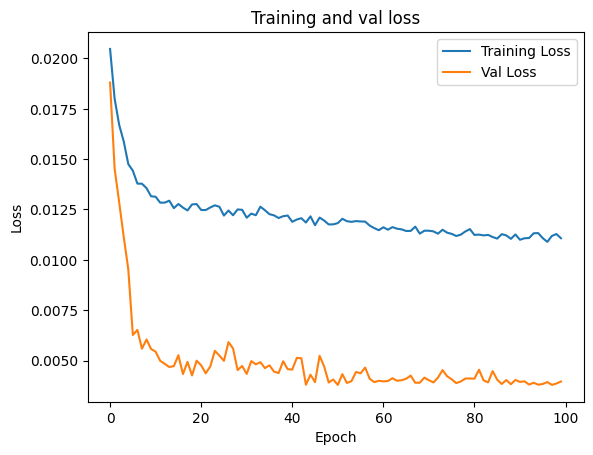

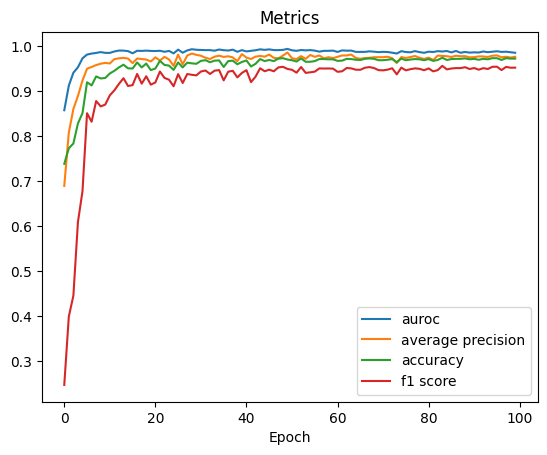

In [ ]:
"""
TASK: Here it can make sense to plot your learning curve; Insert your code here
"""
plt.plot(train_loss_all, label='Training Loss')
plt.plot(valid_loss_all, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and val loss')
plt.legend()
plt.show()

## The addtional code only for us
plt.plot(auroc, label='auroc')
plt.plot(avg_pre, label='average precision')
plt.plot(acc_s, label='accuracy')
plt.plot(f1_s, label='f1 score')

plt.xlabel('Epoch')
plt.ylabel('')
plt.title('Metrics')
plt.legend()
plt.show()

---
## Model Testing

Since we saved our best model, we can now load the trained model and make predictions on the test data set. We save the predictions in a csv file which will be uploaded as part of the deliverables. Note that we take a `Sigmoid()` function on the model prediction in order to obtain hard predction (0,1) instead of soft predictions (probabilities).

### Coding Task 7: Make prediction for test data

Here you do not really need to code but you have to:
- replace the baseline model with your model. If you do not use colab then change the path to the model location to load the trained model)
- run the script. The soft and hard predictions are saved in the variables `soft_pred` and `hard_pred`.
- upload your predictions to the leaderboard online (see instruction details below).

In [ ]:
# build the dataloader once and re-use when running the cell below possibly multiple times.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# =============== Build data loaders ==========================================#
tqdm.write("Building data loaders...")
# load data
path_to_h5_test, path_to_csv_test = 'codesubset/test.h5', 'codesubset/test.csv'
traces = torch.tensor(h5py.File(path_to_h5_test, 'r')['tracings'][()], dtype=torch.float32)
dataset = TensorDataset(traces)
len_dataset = len(dataset)
# build data loaders
test_dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
tqdm.write("Done!\n")

Building data loaders...
Done!



In [ ]:
# =============== Define model ================================================#
tqdm.write("Define model...")
"""
TASK: Replace the baseline model with your model; Insert your code here
"""
model = Model()

# load stored model parameters
ckpt = torch.load('model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(ckpt['model'])
# put model on device
model.to(device=device)
tqdm.write("Done!\n")

# =============== Evaluate model ==============================================#
model.eval()
# allocation
test_pred = torch.zeros(len_dataset,1)
# progress bar def
test_pbar = tqdm(test_dataloader, desc="Testing")
# evaluation loop
end=0
for traces in test_pbar:
    # data to device
    traces = traces[0].to(device)
    start = end
    with torch.no_grad():
        # Forward pass
        model_output = model(traces)

        # store output
        end = min(start + len(model_output), test_pred.shape[0])
        test_pred[start:end] = torch.nn.Sigmoid()(model_output).detach().cpu()

test_pbar.close()

# =============== Save predictions ============================================#
soft_pred = np.stack((1-test_pred.numpy(), test_pred.numpy()),axis=1).squeeze()

Define model...
Done!



Testing:   0%|          | 0/188 [00:00<?, ?it/s]

To upload your predictions to the leaderboard, use the following code. There are the following steps to follow:
1. Download the GitHub repository for the leaderboard submission system.
2. Register your team with a **team id** and **password**. The password ensures that only your team can upload to your team id. Do only run the registration once.
3. Upload you predictions as a new submission. There are some things to obey here:
    - For each submission you have to attach a note for you to keep track of the submission in the leaderboard and for us to know which submission you refer to in your explanation. Choose something meaningful such as "submission A" or "model B".
    - You can only get one prediction evaluated per day and you get the score the following day. If you do multiple submissions on the same day, the initial submission will be overwritten and thus only the final submission will be evaluated.
    - Only a maximum of ***FIVE*** submissions will be evaluated. So make them count! (If you update an submission before it is evaluated it doesn't count)
    - The evaluation score is published with you team_id and note at http://hyperion.it.uu.se:5050/leaderboard



In [ ]:
# 1. Download repository for leaderboard submission system
if not exists('leaderboard'):
    !git clone https://gist.github.com/3ff6c4c867331c0bf334301842d753c7.git leaderboard

Cloning into 'leaderboard'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3
Unpacking objects: 100% (3/3), 631 bytes | 631.00 KiB/s, done.


In [ ]:
# 2. Registration of your team
host = "http://hyperion.it.uu.se:5050/"
runfile("leaderboard/leaderboard_helpers.py")

"""
TASK: Decide for a team_id (max 20 chars) and password. (Done)
Do not change this after you have registered your team
"""
team_id = 'Y' #Fill in a string
password = 'B2023Feb' #Fill in a string

# run the registration
r = register_team(team_id, password)
if (r.status_code == 201):
    print("Team registered successfully! Good luck")
elif not (r.status_code == 200):
    raise Exception("You can not change your password once created. If you need help, please contact the teachers")

In [ ]:
# 3. Upload the prediction as submission

# Write a note about the training procedure so you can identify it in the leaderboard. e.g. 5 epochs, or First  (Max 20 characters)
"""
TASK: Add a note for you submission
"""
note = 'Stable' #Fill in a string

# Submit the predictions to the leaderboard. Note, this also saves your submissions in your colab folder
r = submit(team_id, password, soft_pred.tolist(), note)
if r.status_code == 201:
    print("Submission successful!")
elif r.status_code == 200:
    print("Submission updated!")

Submission successful!


### Explanation Task 4: Submissions
One of the grading criteria are three submissions to the leaderboard. List the three main submissions in the table below and explain the main changes in your code for each submission.

<br />


**<font color='red'>Your explanation here:</font>**

Your team id: **<font color='red'>Y</font>**

| Submission note | Accuracy | F1 | AUC | AP | Submission description |
| --------------- | -------- | -- | --  | -- | ---------------------- |
|TemporaryVer     | 0.951| 0.949| 0.987| 0.985| First version with little oscillation  |
|Stable              | 0.951        | 0.950  | 0.983   | 0.976  | Stable loss curve                   |
|MPtoAP              | 0.950        | 0.949  | 0.982   | 0.972  | Change the output size of kernel                  |

* The first submission 'TemporaryVer' gives an AUC of 0.987 and AP of 0.985, which already meet the requirements.
* To get a better result, we further tuned the model by changing the optimization method from 'Adam' to 'NAdam' to give a bit acceleration, and increasing the dropout rate to get a stronger regularization. This version is called 'Stable'. The result of this version is slightly better than the previous one in terms of F1 score, but slightly lower for AUC and AP.
* The thrid version 'MPtoAP' is to try out different sizes of kernels. This version gives a lower loss and better F1 score on the validation dataset. However, it seems to have no improvment on the test dataset, suggesting that the model does not generalize better.

### Explanation Task 5: Reflection on Metrics
Your were asked to reach a certain value in AUC and AP while maximising F1 for the leaderboard position. Explain in bullet points what aspect each of the metrics covers and why it is important not to just focus on one metric. What can happen if you only focus on AUC for example?

<br />

**<font color='red'>Your explanation here:</font>**
* AUC calculates the area under the ROC curve. It looks at the prediction scores rather than the predicted classes. It considers both true positive rate as well as false positive rate.
* F1 score models the accuracy by combining the precision and the recall. It is considered to be more useful than accuracy when the data is imbalanced. It takes predicted classes instead of predicted scores as in AUC.
* AP is the weighted mean of precision scores across all Percision-Recall curve thresholds. It considers the Percision-Recall relation gloablly compared to the F1 score.
* By considering several metrics, one can get a more complete view of the model, and detect potential issues in the model. For example, high AUC shows that the model is good at separating classes, while high F1 score shows that the model can classify instances well. However, high AUC and low F1 score can occur if the model ranks instances well across all thresholds but struggles with classifying, especially for imbalanced dataset since F1 score balances precision and recall.